In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import *
from fastai.basic_data import *
from fastai.callbacks import CSVLogger
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
from PIL import Image
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [2]:
import numpy as np
import torch
import pandas as pd
import random
import string

In [3]:
model_name = 'efficientnet-b1'

In [4]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(model_name) 

Loaded pretrained weights for efficientnet-b1


In [5]:
np.random.seed(42)

In [6]:
image_size = EfficientNet.get_image_size(model_name)

In [7]:
src = (ImageList.from_folder(path='../../../train/train').split_by_rand_pct(0.2).label_from_folder())

In [8]:
res = []
res.append(rotate(degrees=(-90,90), p=1))

In [9]:
tfms=(res,[])

In [10]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=32).normalize(imagenet_stats))

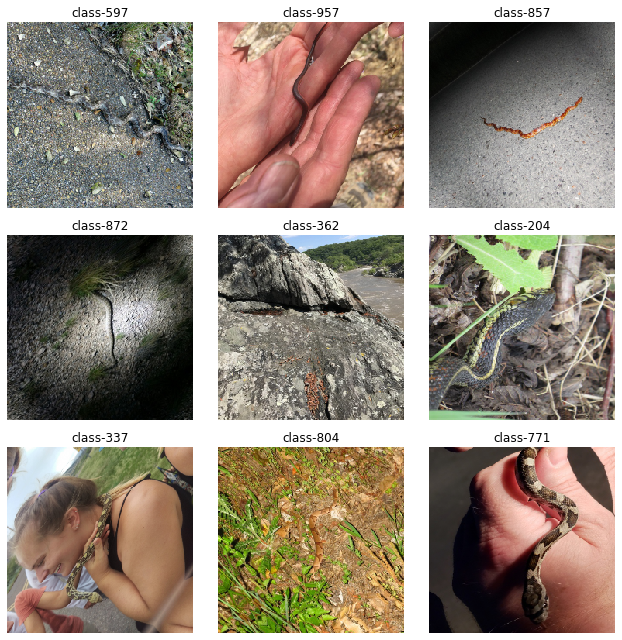

In [11]:
data.show_batch(3,figsize=(9,9))

In [12]:
list(children(model))[-2:]

[Linear(in_features=1280, out_features=1000, bias=True),
 MemoryEfficientSwish()]

In [13]:
model.add_module('_fc',nn.Linear(1280, data.c))

In [14]:
loss_func = LabelSmoothingCrossEntropy()

In [15]:
RMSprop = partial(torch.optim.RMSprop)

In [16]:
from torch.optim import Optimizer

In [17]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [18]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='micro'),kappa, top_k_accuracy, Precision(average='micro'),Recall(average='micro')],callback_fns=[partial(CSVLogger, filename=model_name, append=True)])

In [19]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])
print("pls")

pls


In [20]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(20,max_lr=slice(lr/100,lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best_b1_0')])

epoch,train_loss,valid_loss,accuracy,f_beta,kappa_score,top_k_accuracy,precision,recall,time


In [ ]:
learn.save('b1-trained-for-20', return_path=True)

In [ ]:
learn.export('b1-trained.pkl')